In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #to plot the GMM
#import pypr.clustering.gmm as gmm #to make and sample the GMM
from sklearn.mixture import GaussianMixture as gmm
from scipy.optimize import minimize #to do grad descent to fing argmax
import time #time each iteration
%matplotlib inline
import mpld3 #for plot tools
mpld3.enable_notebook()
import os, time
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.signal import filtfilt, cheby2
from tqdm import tqdm
import scipy.io as sio
from scipy import pi
from scipy.fftpack import fft
from scipy.signal import resample, butter, lfilter, sosfilt, filtfilt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
#from pyriemann.estimation import Covariances
#from pyriemann.channelselection import ElectrodeSelection

In [9]:
import fnmatch
folder = '/Users/macintoshhd//Downloads/FullDatasetCBCI2020/' 
#preprocessed test data folder 
#test = '/Downloads/FullDatasetCBCI2020/' 
train = fnmatch.filter(os.listdir(folder),'parsed_*T.mat')
test = fnmatch.filter(os.listdir(folder),'parsed_*E.mat')
test[0]

'parsed_P01E.mat'

In [10]:
# appending train data and labels and resampling 
labels=[]
data = np.empty((0,12,4096))
for i in train:
    #print('i=',i)
    temp = sio.loadmat(folder+i)
    dat = temp['RawEEGData']
    #print(np.shape(dat))
    lab = np.squeeze(temp['Labels'])
    data = np.concatenate((data, dat), axis=0)
    labels = np.concatenate((labels, lab), axis =0)
    labels = [int(x) for x in labels]
#print(labels)

# appending test data 
tlabels=[]
tdata = np.empty((0,12,4096))
for i1 in test:
    #print('i=',i1)
    temp1 = sio.loadmat(folder+i1)
    tdat = temp['RawEEGData']  #[0:40,:,:]
    print('tdat=', np.shape(tdat)) #, tdat[45:47, :, :])
    tlab = np.squeeze(temp1['Labels'])
    #print(lab)
    tdata = np.concatenate((tdata, tdat), axis=0)
    tlabels = np.concatenate((tlabels, tlab), axis =0)


tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)
tdat= (80, 12, 4096)


In [11]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    n_trials, n_chans, n_time = signal.shape
    filtered = np.zeros(signal.shape)
    print(filtered.shape)
    for i in range(n_trials):
        for j in range(n_chans):
            filtered[i][j] = lfilter(b, a, signal[i][j])
    return filtered


data_train = butter_bandpass_filter(data, 8,35,4096, order=5)
data_test = butter_bandpass_filter(tdata, 8,35,4096, order=5)
print('filtered train data shape', data_train.shape)
print('filtered test data shape', data_test.shape)

(800, 12, 4096)
(800, 12, 4096)
filtered train data shape (800, 12, 4096)
filtered test data shape (800, 12, 4096)


In [12]:
# cropping last 3 second data
d_train = np.empty((400,12,1536))
for i in range(10):
    #print(range(40*i,40*(i+1)))
    d_train[40*i:40*(i+1)] = data_train[40*i:40*(i+1),:,2560:]
    #print(np.shape(d_train[40*i:40*(i+1)]), np.shape(d_train))
    
#dividing data into train and validation for checking model 
training_data = np.empty((32*10,12,1536)); validation_data= np.empty((8*10,12,1536)); training_labels= np.empty((32*10))
validation_labels = np.empty((8*10)) 
for i in range(10):
    training_data[32*i:32*(i+1),:,:],validation_data[8*i:8*(i+1),:,:],training_labels[32*i:32*(i+1)],validation_labels[8*i:8*(i+1)] = train_test_split(d_train[40*i:40*(i+1),:,:],labels[40*i:40*(i+1)], test_size=0.20, shuffle = True)
    

In [35]:
from pyriemann.estimation import Covariances
from pyriemann.channelselection import ElectrodeSelection
from pyriemann.tangentspace import TangentSpace
## enumeration of the splits
covmat = Covariances(estimator='lwf').fit(training_data, training_labels)
cov_train = covmat.transform(training_data)
cov_val = covmat.transform(validation_data)
select_train = TangentSpace().fit_transform(cov_train)
select_val = TangentSpace().fit_transform(cov_val)
print(np.shape(select_train), np.shape(select_val))


(320, 78) (80, 78)


In [36]:
samples = select_train

In [37]:
def expKer(x,samples,gamma):
    #--calcuates the expectation value of the exponential kernel so argmax_x can be found
    #x = candidate super sample to optimize
    #samples = the GMM samples
    #gamma = kernel hyperparameter, always 1 for my demo
    
    #init vars
    numSamples = samples.shape[0]
    k=np.zeros(numSamples)
    #calculate estimate of expectation value of kernel
    for i in range(numSamples):
        k[i] = np.exp(-np.linalg.norm(x-samples[i,:])/gamma**2)
    exp_est = sum(k)/numSamples;
    return exp_est

def sumKer(x,xss,numSSsoFar,gamma):
    #--calcuates the sum of k(x,x_ss) for the number of super samps so far
    #x = candidate super sample to optimize
    #samples = the GMM samples
    #numSSsoFar = number of super sampls so far
    #gamma = kernel hyperparameter, always 1 for my demo
    
    #init vars
    total=0;
    k=np.zeros(numSSsoFar)
    #calculate sof of kernels
    for i in range(numSSsoFar):
        k[i] = np.exp(-np.linalg.norm(x-xss[i,:])/gamma**2)
    total = np.sum(k)
    s = total/(numSSsoFar+1)
    return s

In [38]:
def herd(samples,totalSS,gamma):
    #-- calculate totalSS super samples from the distribution estimated by samples with kernel hyperparam gamma
    
    #init vars and extract useful info from inputs
    #get GMM dims and num samples
    numDim = samples.shape[1]
    numSamples = samples.shape[0]
    print(numDim,numSamples)
    #init vars
    gradientFail = 0; #count when optimization fails, debugging
    xss = np.zeros((totalSS,numDim)) #open space in mem for array of super samples
    i=1
    #gradient descent can have some probems, so make bounds to terminate if goes too far away
    minBound = np.min(samples)
    maxBound = np.max(samples)
    #start our search at the origin, could be a random point
    bestSeed = np.zeros(numDim)
    
#     tick = time.clock()
    while i<totalSS:
        print(".")
        #debugging stuff
        #print "Working on SS num ber i=%d" % i
        #build function for gradient descent to find best point
        f = lambda x: -expKer(x,samples,gamma)+sumKer(x,xss,i,gamma)
        results = minimize(f,
                           bestSeed,
                           method='nelder-mead',
                           options={'xtol': 1e-4, 'disp': False})
#         print "results.x"
#         print results.x
        
        #if grad descent failed, pick a random sample and try again
        if np.min(results.x) < minBound or np.max(results.x) > maxBound:
            bestSeed=samples[np.random.choice(numSamples)]
            gradientFail=gradientFail+1
#             print "Gradient descent failed.............."
            continue
        
        #pick next best start point to start minimization, this is how Chen, Welling, Smola do it
        #find best super sample that maximizes argmax and use that as a seed for the next search
        #init or clear seed array
        seed=np.array([])
        for j in range(i):
            seed = np.append(seed,-expKer(xss[j,:],samples,gamma)+sumKer(xss[j,:],xss,i,gamma))
        bestSeedIdx = np.argmin(seed)
        bestSeed=xss[bestSeedIdx,:]
        
        #grad descent succeeded (yay!), so assign new value to super samples
        xss[i,:]=results.x
        
        i=i+1
        #toc = time.clock()
#         print "Time elapsed %d" % (toc-tick)
    return xss

In [ ]:
totalSS=32
xss = herd(samples,totalSS,gamma=1)

78 320
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


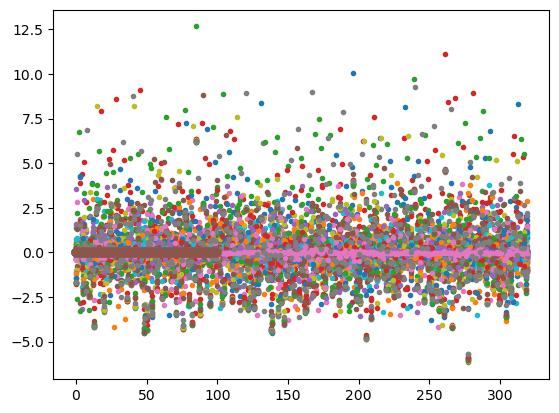

In [43]:
plt.plot(samples[:,:], '.')
plt.plot(xss[:,:],'o')
plt.show()

In [41]:
# Calculate herding error
mu_p = np.mean(samples,axis=0)
err=np.zeros(totalSS)
for i in range(totalSS):
    err[i]    = np.linalg.norm(mu_p-np.sum(xss[1:i,:],axis=0)/i)

idx = np.random.choice(320,totalSS)
print(idx)
samples_iid=samples[idx,:]
err_iid=np.zeros(totalSS)
for i in range(totalSS):
    err_iid[i]= np.linalg.norm(mu_p-np.sum(samples_iid[1:i,:],axis=0)/i)


[165 246 313 160 314 300   9 231 307 299 191 314  24 226  77  77  64 282
 216 230 148 213 240 142 228 293 317  49  71  90 313 223  91 135  99  28
  37  19 241 263  20 281 230 265 234 253  38  73 294  98 137  93  43 238
 138  23  63  53 213 161 102 187 197  89 246 134 136  63 241 210  18  56
  91  21  93  57 245 153 132  94  84 165 236 131 299  38 268 160 267 107
 112 155 279 118 178 229 135 174 245 293]


/var/folders/q1/761cbmm11w961ttk17dyg_7c0000gn/T/ipykernel_6345/3300063677.py:5: RuntimeWarning: invalid value encountered in true_divide
  err[i]    = np.linalg.norm(mu_p-np.sum(xss[1:i,:],axis=0)/i)
/var/folders/q1/761cbmm11w961ttk17dyg_7c0000gn/T/ipykernel_6345/3300063677.py:12: RuntimeWarning: invalid value encountered in true_divide
  err_iid[i]= np.linalg.norm(mu_p-np.sum(samples_iid[1:i,:],axis=0)/i)


In [44]:
totalSS

100

/var/folders/q1/761cbmm11w961ttk17dyg_7c0000gn/T/ipykernel_6345/2477221579.py:6: UserWarning: Legend does not support 'Herding error' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(['Herding error','iid error','~1/N'],'lower left')
/var/folders/q1/761cbmm11w961ttk17dyg_7c0000gn/T/ipykernel_6345/2477221579.py:6: UserWarning: Legend does not support 'iid error' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(['Herding error','iid error','~1/N'],'lower left')
/var/folders/q1/761cbmm11w961ttk17dyg_7c0000gn/T/ipykernel_6345/2477221579.py:6: UserWarning: Legend does not support '~1/N' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding

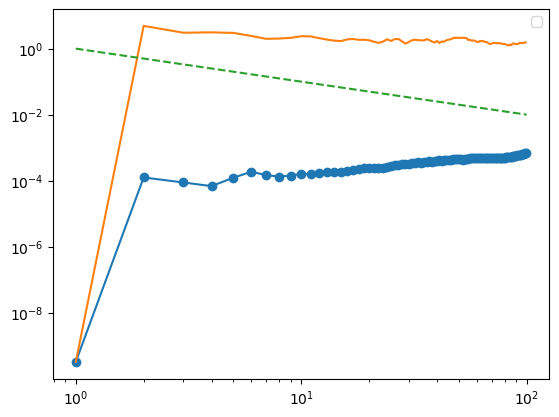

In [42]:
plt.plot(err,'-o')
plt.plot(err_iid)
plt.plot([1,totalSS],[1,1./totalSS],'--')
plt.yscale('log')
plt.xscale('log')
plt.legend(['Herding error','iid error','~1/N'],'lower left')
plt.show()